# Implementation
============================
#### (Using Probabilistic Graphical Models to forecast the price of crude oil)

The document contains the **implementation** of the oil trading system using graphical models.

* [The **first** part](#first) is dedicated to retrieving data from the **EIA** and **FRED**, **preprocessing** the data,and creating the **training**, **validation**, and **test** datasets.
* [The **second** part](#second) is dedicated to implementing a **regime detection model** using **Hidden Markov Models** to identify bull, bear, and stagnant regimes.
* [The **third** part](#third) is dedicated to learning the **macroeconomic structure** of the oil markets by **learning the belief network** using **hill-climbing** structural learning.
* [The **fourth** part](#fourth) is dedicated to **testing** the constructed model by simulating trades and taking positions based on those trades.

It is recommended to take look at the thesis documentation to understand the basis on which we selected the macroeconomic economic data from the EIA and FRED, and the theoretical context of the graphical models being employed in our model. 

We would be using a number of Python packages, such as [pgmpy](http://pgmpy.org/) and [hmms](https://github.com/lopatovsky/HMMs) throughout the notebook and it is highly recommended that we take a deeper look at them as only a specific and relevant functionality of those packages have been used in our model.

## Data preprocessing

Data preprocessing plays an important role in Machine Learning. Our data preprocessing has four main steps;  data retrieval, data cleaning, data transformation, and data discretisation.

### Data retrieval

The first step of constructing our model is to retrieve the data from the open-data facilities. We have selected the **EIA** and **FRED** as our primary data sources. Unfortunately, both these open-data facilities do not provide Python packages to neatly retrieve data in Python, so we will have to resort to using third-party APIs. For the EIA, we are using [EIA-python](https://github.com/mra1385/EIA-python/), and for the FRED we are using [fredapi](https://github.com/mortada/fredapi). 

Before beginning, we would be first be importing pandas and numpy, as they are highly required in the entire data preprocessing section.

In [1]:
import pandas as pd
import numpy as np

We would now be retrieving data, beginning with the EIA. Before retrieving data from the EIA, we have to register with EIA's [open-data facility](https://www.eia.gov/opendata/), in return of which we shall recieve an API key, which is used as a passphrase to access data from the EIA's datacenter. 

In [2]:
# Importing the library
import eia 
# the API key we recieved from EIA
eia_key = "265d1f2178aaab3ceec3d364d9cc1d11"; 
# Initiates a session with the EIA datacenter to recieve datasets
eia_api = eia.API(eia_key); 

Now, we shall be making a request to retrieve data from the EIA as a pandas dataframe. EIA provides a 3,872 Short-Term Energy Outlook (STEO) datasets, with short-term (2-year) forecasts of each dataset. These datasets can be searched in EIAs [query browse](https://www.eia.gov/opendata/qb.php) facility, which also offers a catalogue of different datasets sorted by relevance. Just as an example to demonstrate, we would be retrieving the **Crude Oil Exports, Monthly**, which has a Series ID '**TOTAL.COEXPUS.M**'.

In [3]:
# Convert to pandas dataframe
eia_data = pd.DataFrame(eia_api.data_by_series(series='TOTAL.COEXPUS.M')); 

### Data Cleaning

Taking a look at the dataframe, we can observe some evident inconsistencies. 

Firstly, the dataframe provided by the EIA is not of the standard format **datetime**, which pandas indexing supports and provides extensive facility to. We would be writing a function which makes the index a **datetime** object so that we can convert the dataframe to a **datetime**-index dataframe for more compatibility with pandas, hmms, and pgmpy.

In [4]:
import datetime # Using the datetime library

def convert_to_datetime(input):
            return datetime.datetime.strptime(input[:9], "%Y %m ").date();

# Apply to entire index
eia_data.index = eia_data.index.map(convert_to_datetime); 
# Convert dataframe index to datetime64[ns] index
eia_data.index = pd.to_datetime(eia_data.index); 
# pgmpy stores the column names as the variable name
eia_data.columns = ['TOTAL.COEXPUS.M']; 

The second issue are **holes** in the data i.e. rows marked by a '-' (a single dash). We would be replacing these dashes by **np.nan** so that we can use pandas to fill in the holes. Usually the prevalance of these holes is very rare, but just to be on the safe side to ensure we can possibly download every dataset.

In [5]:
# Replace the '-' with np.nan
eia_data.replace('-', np.nan, regex=True, inplace=True); 
# Backward fill the holes, by filling them with the data infront.
eia_data.fillna(method='bfill', inplace=True); 

Together, we can create a function carrying out the entire process so that we can easily clean EIA data in one step.

In [6]:
def clean_EIA(data):
            data.replace('-', np.nan, regex=True, inplace=True);
            data.fillna(method='bfill', inplace=True);
            
            data.index = data.index.map(convert_to_datetime);
            data.index = pd.to_datetime(data.index);

The dataframe is now a time series dataframe which could be plotted as a time-series dataframe.

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,6));
ax.plot(eia_data);

Now, we shall be taking a look at the FRED data. Similar to [EIA-python](https://github.com/mra1385/EIA-python/), the [fredapi](https://github.com/mortada/fredapi) requires us to register with [FRED API](https://research.stlouisfed.org/docs/api/fred/) so that we can access data. We would download the **Spot Crude Oil Price: West Texas Intermediate**, having the Series ID '**WTISPLC**.'

In [8]:
from fredapi import Fred

# FRED API key
fred_key = "029c72315e9ec4eaf3e679ec3f6a2cb3"; 

# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key); 

# Retrieve data from FRED API
fred_data = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC']); 

It is evident that the FRED, though still being a government organization, has 'ready-to-use' / 'plug'n play' data of useable quality compared to the EIA. Fortuntely, we will not be having to clean data obtained from the FRED.


### Constructing the training, validation and testing datasets (Data transformation)

As mentioned in the thesis, we need to divide our data in three portions: the training dataset, the validation dataset, and the training dataset. Given that we would be using a number of datasets from the FRED and the EIA, we would have to amalgamate these datasets into one dataframe and then slice the dataframe accordingly. 

The train, validation, and test datasets are to be observed with a ratio of $80:10:10$, which is a popular ettiquette  

The choice of datasets has been described in the thesis.

In [9]:
# Dataset series ID from the EIA

datasets_eia  = [
    
                        'STEO.RGDPQ_NONOECD.M',
                        'STEO.RGDPQ_OECD.M',
    
                        'STEO.PAPR_NONOPEC.M',
                        'STEO.PAPR_OPEC.M',
    
                        'STEO.PATC_OECD.M',
                        'STEO.PATC_NON_OECD.M',
                
    
                        'STEO.COPRPUS.M',
                        'STEO.CORIPUS.M',
                        'PET.MCRIMXX2.M',
                        
                        'STEO.FOREX_WORLD.M',
    
                        'STEO.PASC_OECD_T3.M',
    
                        'STEO.COPS_OPEC.M',
                        'STEO.COPC_OPEC.M',
    
                        'STEO.T3_STCHANGE_OOECD.M',
                        'STEO.T3_STCHANGE_NOECD.M',
                ];

# Dataset series ID from the FRED

datasets_fred = [
                        'CPIENGSL',
                        'CAPG211S',
                        'CAPUTLG211S',
                        'IPG211S',
                        'IPG211111CN',
                        'INDPRO',
                        'IPN213111N',
                        'PCU211211',
                
                ];

To construct the training, validation, and testing datasets, we need to first **concatenate** the datasets into one dataframe, and then slice it.

In [10]:
data_merge = []; # List of dataframes to be concatenated

# Adding EIA datasets 

for series_id in datasets_eia:
        df = pd.DataFrame(eia_api.data_by_series(series=series_id));
        clean_EIA(df);
        df.columns = [series_id];   
        data_merge.append(df);

# Adding FRED datasets 

for series_id in datasets_fred:
        df = pd.DataFrame(fred.get_series(series_id), columns=[series_id]);
        data_merge.append(df);

We have to create two additional columns; one which has the current crude oil price, and the other for the price of crude oil next month (forecast). This will be used to forecast the price of oil and hence allow us to make buy/sell decisions based on that forecast. 

In [11]:
datasets = datasets_eia + datasets_fred + ['WTISPLC', 'forecast'];

current =  pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC']);
forecast = pd.DataFrame(fred.get_series('WTISPLC').shift(-1), 
                        columns=['forecast']);

data_merge.append(current);
data_merge.append(forecast);

We have to amalgamate all datasets together in a single dataframe, therefore we would use the pandas **concatenate** function. This would allow us to find the intersection of the date intervals of all dataframes and construct a single dataframe on a common time interval. 

In [12]:
data = pd.concat(data_merge, axis=1, join='inner');

Slicing our dataframe in train, validation, and testing datasets,

In [13]:
train_data = data[: int(data.shape[0] * 0.80)];
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])];
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])];

### Data Discretisation

The data we have collected is non-categorical data; it is unlabelled and continuous. Belief networks have variables, each having discrete **states**, and therefore we have to reduce our data from prices to a set of states, such as bull, bear, and stagnant markets. In order to detect these (hidden) states, we have to use graphical models called **Hidden Markov Models**. The process of detecting hidden states in time-series data is called **Regime Detection**.

## Regime Detection

We would be using Python library called [hmms](https://github.com/lopatovsky/HMMs) for implementing the **Hidden Markov Models**.

A **Hidden Markov Model** is a 5-tuple $(Q, \sum, \Pi, A, B)$, where $Q = \{q_{1}, \cdots, q_{N}\}$ is a finite set of $\mathcal{N}$ states, $\sum = \{s_1, \cdots, s_{N}\}$ is the set of $\mathcal{M}$ possible symbols (emissions) in the language, $\Pi = \{\pi_{i}\}$  is the initial probability vector, $A = \{a_{ij}\}$ is the state transition probability matrix, and $B = \{b_i(v_k)\}$ is the emission probability matrix. The HMM can be denoted by $\lambda = (\Pi, A, B)$.

For detecting regimes in time-series data, we would be using **Hidden Markov Models**, with the difference between consecutive months being the symbols $\sum$ (1 - increase / 0 - decrease), the hidden states, $Q$ being the **bull**, **bear**, **stagnant** market regimes. 

Let us use '**WTISPL**' (Spot Crude Oil Price: West Texas Intermediate)  of  and try to identify regimes in the time series. 

In [14]:
import hmms

In [15]:
price = train_data['WTISPLC'];

We will now try to transform the time series which represents the output emissions, with $1$ representing an increase in the price from the previous month and $0$ representing a decrease in the price of the oil. 

In [16]:
# The first value is NaN as there is not a previous month to compare with
price_diff = price.diff()[1:]; 

# Replacing the change with 1 if positive, else 0
e_seq = np.array(price_diff.apply(lambda x: 1 if x > 0 else 0).values);

Given that we have obtained the output (observed emission sequence), we can now use the **Baum-Welch algorithm** to learn the parameters of the HMM generating this data. 

We have earlier described the **Baum-Welch algorithm** in the Background and Literature review, and we would be using the implementation provided [hmms](https://github.com/lopatovsky/HMMs) to learn the parameters.

**IT IS VERY IMPORTANT** to note we can **only** use the training data to train the HMM as we are assuming to be blind to the testing data. However, we would be observing predictions on the validation dataset and will tune our model to fit it, and we would be using the testing dataframe to test the final performance of the tuned model after validation.

We will create a model with random parameters, that will be eventually trained to match the data - a discrete time HMM of three hidden states (bull, bear, or stagnant) and two output variables (increase or decrease).

In [17]:
dhmm_r = hmms.DtHMM.random(3 , 2); 

Given that the $\texttt{hmms.DtHMM}$ takes a list of arrays no creater than length $32$, we will have to split our array in arrays each of length $32$ or less.

In [18]:
e_seq = np.array_split(e_seq, 32);

### Baum-Welch Algorithm

We would now be using the **Baum-Welch algorithm** to learn the parameters of the HMM generating the time-series.

The probability of the reestimated model after each iteration should ideally be closer that the (unknown) generator's model, however chances might be the estimation fell in the local optima. 

Unfortunately, the financial time-series data do not have fixed parameters, so the HMM has to be trained everytime when live-trading, when using the **k-fold cross-validation** training method.

In [19]:
dhmm_r.baum_welch(e_seq, 100); # 100 iterations

iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

We have now learnt the parameters generating the emission sequence.

In [20]:
hmms.print_parameters( dhmm_r );

Initial probabilities (π) :


,0
0,0.183528
1,0.178804
2,0.637669


Transition probabilities matrix (A):


,0,1,2
0,0.272157,0.453520,0.274323
1,0.289379,0.385064,0.325557
2,0.742251,0.074114,0.183635


Emission probabilities matrix (B):


,0,1
0,0.254250,0.745750
1,0.907314,0.092686
2,0.067777,0.932223


### Viterbi Algorithm

Now, given we now have parameters $\lambda$ and the emitted observation sequence $\texttt{e_seq}$, we can use the **Viterbi Algorithm** to identify the most likely **state-transition** path (i.e. **market regimes**) in the financial time-series. 

In [21]:
( log_prob, s_seq ) =  dhmm_r.viterbi(np.concatenate(e_seq).ravel());

### Multicolored time series plot

Now, we will be plotting this graph in a **multicolored** time-series plot to observe how well the regimes have been identified.

First, we will have to make a dataframe which has the both the price and the associated regime the time-series data is in.

In [22]:
# Add price
price_plot = pd.DataFrame(price[1:], index=price[1:].index); 

# Add a column representing the regime 
price_plot['Regime'] = s_seq; 

# Add a column representing the increase or decrease in price
price_plot['diff'] = price_diff; 

We do not know, however, which state represents which regime. Given that the bull regimes should have a high positive change in price, bear regimes should have a high negative change, and stagnant regimes are closer to zero, we can use these properties to tell which state represents which regime.

In [23]:
# Get means of all assigned states
means = price_plot.groupby(['Regime'])['diff'].mean(); 
lst_1 = means.index.tolist();
lst_2 = means.sort_values().index.tolist();

map_regimes = dict(zip(lst_2, lst_1));

price_plot['Regime'] = price_plot['Regime'].map(map_regimes);

Plotting the data as **multi-colored** time series:

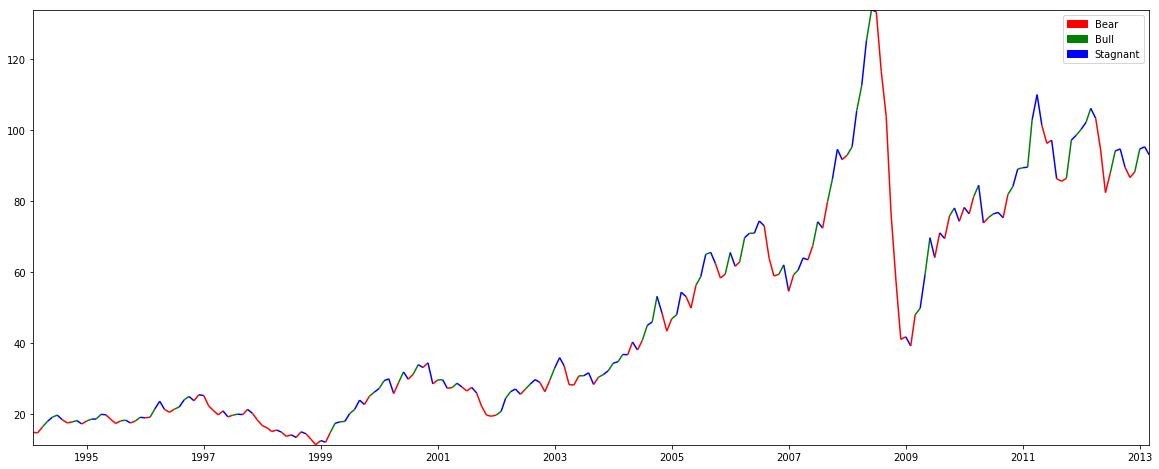

In [24]:
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm

fig, ax1 = plt.subplots(figsize=(20,8));
ax.plot(price_plot['WTISPLC']);

# Make 0 (Bear) - red, 1 (Stagnant) - blue, 2 (Bull) - green 

cmap   = ListedColormap(['r','b','g'],'indexed'); 
norm   = BoundaryNorm(range(3 + 1), cmap.N);
inxval = mdates.date2num(price_plot['WTISPLC'].index.to_pydatetime());
points = np.array([inxval, price_plot['WTISPLC']]).T.reshape(-1, 1, 2);
segments = np.concatenate([points[:-1], points[1:]], axis=1);

lc = LineCollection(segments, cmap=cmap, norm=norm);
lc.set_array(price_plot['Regime']);
plt.gca().add_collection(lc);
plt.xlim(price_plot['WTISPLC'].index.min(), price_plot['WTISPLC'].index.max());
plt.ylim(price_plot['WTISPLC'].min(), price_plot['WTISPLC'].max());

r_patch = mpatches.Patch(color='red', label='Bear');
g_patch = mpatches.Patch(color='green', label='Bull');
b_patch = mpatches.Patch(color='blue', label='Stagnant');

plt.legend(handles=[r_patch, g_patch, b_patch]);

plt.show();

We can observe from the graph that there are periods of bear runs, bull runs, and stagnant periods. Now, we need to apply a similar method to all the training data so that we can discretise our data and use it as an input to our belief network.

### Discretising dataframes using Hidden Markov Models 

We will write a function that trains an HMM, identifies the sequence of hidden states, and then constructs a dataframe of all the variables and stores it as training dataset.

Now, we shall apply the same method to the entire training dataset so that we can discretise it.

First, we shall learn all the parameters of Hidden Markov Models of all the variables and store them. 

In [25]:
for series_id in datasets:
    if series_id == 'forecast':
        break;
    else:
        dhmm = hmms.DtHMM.random(3,2);
        data_diff =  train_data[series_id].diff()[1:];
        emit_seq = np.array_split(data_diff.apply(
                    lambda x: 1 if x > 0 else 0).values, 32);
        dhmm.baum_welch(emit_seq, 100);
        path = "./hmms/" + series_id.replace(".", "_");
        dhmm.save_params(path);


iteration  1 / 100
iteration  2 / 100
iteration  3 / 100
iteration  4 / 100
iteration  5 / 100
iteration  6 / 100
iteration  7 / 100
iteration  8 / 100
iteration  9 / 100
iteration  10 / 100
iteration  11 / 100
iteration  12 / 100
iteration  13 / 100
iteration  14 / 100
iteration  15 / 100
iteration  16 / 100
iteration  17 / 100
iteration  18 / 100
iteration  19 / 100
iteration  20 / 100
iteration  21 / 100
iteration  22 / 100
iteration  23 / 100
iteration  24 / 100
iteration  25 / 100
iteration  26 / 100
iteration  27 / 100
iteration  28 / 100
iteration  29 / 100
iteration  30 / 100
iteration  31 / 100
iteration  32 / 100
iteration  33 / 100
iteration  34 / 100
iteration  35 / 100
iteration  36 / 100
iteration  37 / 100
iteration  38 / 100
iteration  39 / 100
iteration  40 / 100
iteration  41 / 100
iteration  42 / 100
iteration  43 / 100
iteration  44 / 100
iteration  45 / 100
iteration  46 / 100
iteration  47 / 100
iteration  48 / 100
iteration  49 / 100
iteration  50 / 100
iteration

Now, we shall be constructing the discretised training dataframe. 

In [26]:
disc_test = pd.DataFrame(index = train_data[1:].index);

for series_id in datasets:
    path = "./hmms/" + series_id.replace(".", "_") + ".npz";
    if series_id == 'forecast':
        dhmm = hmms.DtHMM.from_file('./hmms/WTISPLC.npz');
    else:
        dhmm = hmms.DtHMM.from_file(path);
    data_diff =  train_data[series_id].diff()[1:];
    emit_seq = np.array(data_diff.apply(
                lambda x: 1 if x > 0 else 0).values);
    ( log_prob, s_seq ) =  dhmm.viterbi(emit_seq);
    disc_test[series_id] = s_seq;

disc_test.to_csv("./data/train_data.csv"); # Saving to CSV

### (Recommended) Plotting Regime Switch plots

In order to verify if the **HMM** has correctly identified regimes in all datasets, we should plot the **regime-switching models** of all datasets and observe if the **bull**, **bear**, and **stagnant** states have been correctly identified. The graphical representation allows us to understand how the regimes have been learnt. 

Omission of this step can result in the **HMM** being incorrectly trained, hence identifying incorrect regimes consequently affecting the belief network's training and prediction process. 

In [27]:
states = pd.read_csv("./data/train_data.csv", index_col=0);

for series_id in datasets:
    
        df = pd.DataFrame(index=train_data[1:].index);
        df[series_id] = train_data[series_id][1:];
        df['Diff'] = train_data[series_id].diff()[1:];
        df['Regime'] = states[series_id];
        
        # Get means of all assigned states
        means = df.groupby(['Regime'])['Diff'].mean(); 
        lst_1 = means.index.tolist();
        lst_2 = means.sort_values().index.tolist();

        map_regimes = dict(zip(lst_2, lst_1));
        df['Regime'] = df['Regime'].map(map_regimes);
        
        
        cmap   = ListedColormap(['r','b','g'],'indexed');
        norm   = BoundaryNorm(range(3 + 1), cmap.N);
        inxval = mdates.date2num(df[series_id].index.to_pydatetime());
        points = np.array([inxval, df[series_id]]).T.reshape(-1, 1, 2);
        segments = np.concatenate([points[:-1], points[1:]], axis=1);

        lc = LineCollection(segments, cmap=cmap, norm=norm);
        lc.set_array(df['Regime']);
        plt.gca().add_collection(lc);
        plt.xlim(df[series_id].index.min(), df[series_id].index.max());
        plt.ylim(df[series_id].min(), df[series_id].max());

        r_patch = mpatches.Patch(color='red', label='Bear');
        g_patch = mpatches.Patch(color='green', label='Bull');
        b_patch = mpatches.Patch(color='blue', label='Stagnant');

        plt.legend(handles=[r_patch, g_patch, b_patch]);

        name = "./plots/" + series_id.replace(".", "_") + ".png";

        plt.savefig(name);
        plt.close();

We have sucessfully discretised our training dataset and would now be using it to train the Belief Network.

### Learning Bayesian Network using Hill Climbing

Given that we have discretised our training dataset, we can now use [pgmpy](http://pgmpy.org/) to construct a belief network of all the variables. 

We would be using the **Hill Climbing** approach to learn the belief network. We have given a brief description of the Hill Climbing algorithm in the thesis and would now be using its implementation pgmpy to learn the structure of the oil markets.  

We shall begin with importing the relevant modules from pgmpy in Python.

Given we would be using the *BIC Scoring Algorithm* as the scoring function for Hill Climbing, we will import the relevant functions from the relevant module in pgmpy. 

In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import BicScore, K2Score, BdeuScore

# Retrieve training set
train_data = pd.read_csv("./data/train_data.csv", index_col=0); 

We shall now be performing a Hill-Climbing search. As difficult as it seems, it is a quite straightforward process.

We construct a instance of a Bayesian model, having the initial structure constructed by expert knowledge from EIA. We shall then use Hill Climbing to 'attach' remaining macroeconomic variables to the constructed model.

In [ ]:
#  Initialise Hill Climbing Estimator
hc = HillClimbSearch(train_data, scoring_method=K2Score(train_data)); 
expert =  BayesianModel();
expert.add_nodes_from(datasets);
expert.add_edges_from([
                        ('STEO.PAPR_NONOPEC.M', 'WTISPLC'), 
                        ('STEO.PAPR_OPEC.M', 'WTISPLC'),
                        ('STEO.PATC_OECD.M', 'WTISPLC'),
                        ('STEO.PATC_NON_OECD.M', 'WTISPLC'),
                        ('STEO.RGDPQ_OECD.M', 'STEO.PATC_OECD.M'),
                        ('STEO.RGDPQ_NONOECD.M', 'STEO.PATC_NON_OECD.M'),
                      ]); 

model = hc.estimate(expert); # Performs local hill climb search

model.fit(train_data,
          state_names=dict(map(lambda e: (e, [0, 1, 2]), datasets)), 
          estimator=BayesianEstimator, prior_type="K2");

In [ ]:
import networkx as nx
import pylab as plt


G=nx.Graph();
G.add_edges_from(model.edges());
pos = nx.spring_layout(G);
nx.draw_networkx_nodes(G, pos, node_size = 10);
nx.draw_networkx_edges(G, pos, arrows=True);
plt.figure(5,figsize=(20,10));

We can also represent our model in the form of a directed graph, using NetworkX.

We have now fitted our model using the Hill Climb search, and now can make inferences using forecasts as evidence. 

## Validation

We have successfully fitted our model to the data and need to test our model now.

We will now be using our **validation** dataset and would be making predictions on that and would be accordingly adjusting our model if we are not satisfied by the performance.

We first have to discretise the validation dataset. We would be using the HMMs trained on the **training set**. We **CANNOT** use the **validation set** to train anything, including HMMs! 

In [ ]:
discrete_vald = pd.DataFrame(index = vald_data[1:].index);

for series_id in datasets:
    path = "./hmms/" + series_id.replace(".", "_") + ".npz";
    if series_id == 'forecast':
        dhmm = hmms.DtHMM.from_file('./hmms/WTISPLC.npz');
    else:
        dhmm = hmms.DtHMM.from_file(path);
    data_diff =  vald_data[series_id].diff()[1:];
    emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values);
    ( log_prob, s_seq ) =  dhmm.viterbi(emit_seq);
    discrete_vald[series_id] = s_seq;

discrete_vald.to_csv("./data/validation_data.csv"); # Saving to CSV

Now, we shall be plotting this data to see how well the trained HMMs predicted regimes on the valdiation dataset.

In [ ]:
states = pd.read_csv("./data/validation_data.csv", index_col=0);

for series_id in datasets:
    
        df = pd.DataFrame(index=vald_data[1:].index);
        df[series_id] = vald_data[series_id][1:];
        df['Diff'] = vald_data[series_id].diff()[1:];
        df['Regime'] = states[series_id];
        
        # Get means of all assigned states
        
        means = df.groupby(['Regime'])['Diff'].mean(); 
        
        lst_1 = means.index.tolist();
        lst_2 = means.sort_values().index.tolist();

        map_regimes = dict(zip(lst_2, lst_1));
        df['Regime'] = df['Regime'].map(map_regimes);
        
        
        cmap   = ListedColormap(['r','b','g'],'indexed');
        norm   = BoundaryNorm(range(3 + 1), cmap.N);
        inxval = mdates.date2num(df[series_id].index.to_pydatetime());
        points = np.array([inxval, df[series_id]]).T.reshape(-1, 1, 2);
        segments = np.concatenate([points[:-1], points[1:]], axis=1);

        lc = LineCollection(segments, cmap=cmap, norm=norm);
        lc.set_array(df['Regime']);
        plt.gca().add_collection(lc);
        plt.xlim(df[series_id].index.min(), df[series_id].index.max());
        plt.ylim(df[series_id].min(), df[series_id].max());

        r_patch = mpatches.Patch(color='red', label='Bear');
        g_patch = mpatches.Patch(color='green', label='Bull');
        b_patch = mpatches.Patch(color='blue', label='Stagnant');

        plt.legend(handles=[r_patch, g_patch, b_patch]);

        name = "./plots/" + series_id.replace(".", "_") + "_VALIDATION.png";

        plt.savefig(name);
        plt.close();

Now, we would be predicting the validation sets (forecast for Spot Crude Oil price, WTI Monthly). 

For that, we have to drop the forecast column and then do an inference on the model. 

In [ ]:
# Record real data observation, to be compared with the predicted one
vald_real = states['WTISPLC'].as_matrix(); 

# Drop the real data observation so that it does not bias prediction
vald_data_new = states.drop('forecast', axis=1); 

# Inference on the constructed graphical model
vald_prediction = model.predict(vald_data_new); 

# Retrieve it as an array so we can compare with real value
pred_value_vald = vald_prediction['forecast'].as_matrix(); 

In [ ]:
print("\nPredicted Value: ");
print(pred_value_vald);
print("\nReal Value: ");
print(vald_real);

error = np.mean(vald_real !=  np.roll(pred_value_vald, 1));
#error = np.mean(vald_real != pred_value_vald);
print("\nError: ");
print(error * 100);

Now, we are going to trade on the predictions and compare the performance of the algorithm on returns, beginning with one oil share.

If we have achieved reasonable satisfaction of results on the **validation set**, we can now move to using the **test** set, and check the performance of our algorithm on that. 

The **validation step** is to adjust the model if the error is too high. In this case, we can start again by learning the Bayesian model via the Hill Climbing method and observe the change in performance. We should however, **not** use the **test set** unless and until we are satisfied with the performance of the model on the **validation set**. 

One way of assessing the quality of a network structure is by examining the **connectedness** of the graph, ensuring there are almost no forests, and **the variables which are being forecasted** are part of a denser tree. If we happen to see disconnected trees, we should run our Hill Climbing method again to ensure that the Hill Climber **converges** to either ideally a **global maximum** or atleast a better **local maximum**. 

### Testing

Similar to what we did with the validation data set, we first have to discretise the test dataset, and predict it on the *BayesianModel*.

In [ ]:
discrete_test = pd.DataFrame(index = test_data[1:].index);

for series_id in datasets:
    path = "./hmms/" + series_id.replace(".", "_") + ".npz";
    if series_id == 'forecast':
        dhmm = hmms.DtHMM.from_file('./hmms/WTISPLC.npz');
    else:
        dhmm = hmms.DtHMM.from_file(path);
    data_diff =  test_data[series_id].diff()[1:];
    emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values);
    ( log_prob, s_seq ) =  dhmm.viterbi(emit_seq);
    discrete_test[series_id] = s_seq;

discrete_test.to_csv("./data/test_data.csv"); 

We would now import the (discretised) test dataframe, remove the column containing forecast column as we are predicting it, and input it in our learnt model. We would compare the output to the real values and make a final conclusion of the reliability of the model.

In [ ]:
discrete_test = pd.read_csv("./data/test_data.csv", index_col=0);

# Record real data observation, to be compared with the predicted one
test_real = discrete_test['WTISPLC'].as_matrix(); 

# Drop the real data observation so that it does not bias prediction
test_data_new = discrete_test.drop('forecast', axis=1); 

# Inference on the constructed graphical model
test_prediction = model.predict(test_data_new); 

# Retrieve it as an array so we can compare with real value
pred_value_test = test_prediction['forecast'].as_matrix(); 

In [ ]:
print("\nPredicted Value: ");

# This is the price, not the forecast
print(pred_value_test); 
print("\nReal Value: ");
print(test_real);

# Shift to get forecast
error = np.mean(test_real != np.roll(pred_value_test, 1)); 
#error = np.mean(test_real != pred_value_test); # Shift to get forecast
print("\nError: ");
print(error * 100);

Now, we can use the discretised price predictions to construct a simple trading algorithm, which takes '0' as a shorting signal, '2' for a long position, and '1' for no action. We assume we start with one barrel of oil and we would be trading it to acquire a larger unit.

In [ ]:
test_price = pd.DataFrame(test_data['WTISPLC'], columns=['WTISPLC']);
test_signal = pd.DataFrame(test_prediction, columns=['forecast']);
test_sheet = pd.concat([test_price, test_signal], axis=1, join='inner');

trades = [test_sheet['WTISPLC'].iloc[0]];

position = False; # True for Long, False for Short

for i in range(len(test_sheet)-1):
    if test_sheet['forecast'].iloc[i+1] == 0:
        trades.append(trades[-1]);
    elif test_sheet['forecast'].iloc[i+1] == 2:
        if position == False:
            position = True;
            trades.append(trades[-1]);
        else:
            trades.append(test_sheet['WTISPLC'].iloc[i+1]);
    else:
        trades.append(trades[-1]);

eia_forecast = pd.read_csv("./data/eia_forecast.csv", index_col=0);
eia_forecast.index = test_signal.index;
test_performance = pd.DataFrame(trades, index = test_signal.index, 
                                            columns=['performance']);
test_sheet = pd.concat([test_sheet, test_performance], axis=1, join='inner');


plt.plot(test_sheet['WTISPLC'], 'r');
plt.plot(test_sheet['performance'], 'g');
plt.plot(eia_forecast['eia_forecast'], 'b');

r_patch = mpatches.Patch(color='red', label='WTI Crude Oil Price');
g_patch = mpatches.Patch(color='green', label='Bayesian Model');
b_patch = mpatches.Patch(color='blue', label='EIA Forecast');

plt.legend(handles=[r_patch, g_patch, b_patch], loc = 'lower right');

As we can see, the algorithm has successfully managed to hedge the risk in the early quarter of 2015, but did end up shorting in a bull run in late 2017/early 2018. 

We can also compare the performance of the model with the performance of the EIA forecasts, where we can see the EIA forecasted a bull run when it was a bear run in early 2016. We can also similarly compare the performance in 2017 where both the EIA and the Bayesian Model predicted the the price will remain **stagnant**, however, in reality, it was a bull run. 

We **conclude** that our model performs **better** than the **EIA forecast**, however, **does not** perform better than the index.